### Prepare imports

In [1]:
import os
import zipfile
import mygene
from tqdm import tqdm
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

### Functions

In [2]:
def get_genes_from_table(table):
    return [gene for sublist in table.values.tolist() 
                 for gene in sublist if str(gene) != "nan"]


# Set first only false to get all symbols equivalent to ensembl id
def symbol_to_ensembl(symbols, firstonly=True):
    mg = mygene.MyGeneInfo()
    result = [g.get("ensembl") for g in mg.querymany(symbols, scopes="symbol", fields=["ensembl.gene"], species="human", verbose=False)]
    gene_lists = [gene for gene in result if gene != None]
    genes_single = [gene for gene in gene_lists if type(gene) != list]
    
    if firstonly:
        genes_multiple = [genes[0] for genes in gene_lists if type(genes) == list]
    else:
        genes_multiple_unflattened = [genes for gene in gene_lists if type(genes) == list]
        genes_multiple = [item for sublist in genes_multiple_unflattened for item in sublist]
        
    genes = genes_multiple + genes_single
    ensembl = [gene["gene"] for gene in genes]
    return ensembl


def ensembl_to_symbol(ensembl):
    mg = mygene.MyGeneInfo()
    return [g.get("symbol") for g in mg.querymany(ensembl, scopes="ensembl.gene", fields=["symbol"], species="human", verbose=False)]
    

### Define files and directories

In [3]:
SCRNASEQ_SMARTSEQ2_DATASET = "GSM3828672_Smartseq2_GBM_IDHwt_processed_TPM.tsv"
CELLSTATE_GENE_SELECTION_FILE = "genes_spheroid_cellstate.csv"
SCRNASEQ_METADATA_FILE = "IDHwt.GBM.Metadata.SS2.txt"
SPHEROID_DATASET = "GCRMANormData_.txt"

# Get the project directory path (project)
PROJECT_DIR = Path(os.getcwd()).parent
# Data directory
DATA_DIR = os.path.join(PROJECT_DIR, "1_data")
# Experiment directories
OUT_DIR = os.path.join(PROJECT_DIR, "3_experiments")


SCRNASEQ_SMARTSEQ2_DATASET_PATH = os.path.join(DATA_DIR, 
                                               "3_Neftel_scRNAseq",
                                               SCRNASEQ_SMARTSEQ2_DATASET)

SCRNASEQ_METADATA_PATH = os.path.join(DATA_DIR, 
                                      "3_Neftel_scRNAseq",
                                      SCRNASEQ_METADATA_FILE)

# Cell state genes
CELLSTATE_GENE_SELECTION_PATH = os.path.join(DATA_DIR, 
                                            "3_Neftel_scRNAseq",
                                            CELLSTATE_GENE_SELECTION_FILE)

SPHEROID_DATASET_PATH = os.path.join(DATA_DIR, 
                                     "4_spheroid_microarray",
                                     SPHEROID_DATASET)

### Load data

In [4]:
# Metadata
cellstate_gene_selection = pd.read_csv(CELLSTATE_GENE_SELECTION_PATH, 
                                          header=None, sep=";")
sc_metadata = pd.read_csv(SCRNASEQ_METADATA_PATH, sep="\t", index_col="NAME")

In [5]:
# Load scRNAseq data (Creating this dataframe might take time...)
sc_rnaseq_smartseq2 = pd.read_csv(SCRNASEQ_SMARTSEQ2_DATASET_PATH, sep='\t', index_col="GENE")
# Load spheroid data
spheroid_data = pd.read_csv(SPHEROID_DATASET_PATH, sep="\t", index_col="ENSG_ID")

***
## Data formatting

In [6]:
print("{} selected genes for estimating cell state distributions".format(
    len(get_genes_from_table(cellstate_gene_selection))))

289 selected genes for estimating cell state distributions


In [7]:
# Filter out genes not associated with Neftel cell states (or cycling cell meta-modules)
smartseq2_spheroid_cellstates = sc_rnaseq_smartseq2[sc_rnaseq_smartseq2.index.isin(
                                list(
                                    set(sc_rnaseq_smartseq2.index.tolist()
                                       ).intersection(
                                    set(get_genes_from_table(
                                        cellstate_gene_selection)))))]

### Prepare spheroid data

In [8]:
# Filter out redundant genes
spheroid_data_adapted = spheroid_data[spheroid_data.index.isin(
                                symbol_to_ensembl(smartseq2_spheroid_cellstates.index))]

# Change gene index from ensembl to symbol
spheroid_data_adapted.index = ensembl_to_symbol(spheroid_data_adapted.index)

spheroid_data_adapted = round(spheroid_data_adapted, 5).astype('float32')

spheroid_data_adapted

,A3862_142,A3862_153,A3862_155,A3862_140,A3862_143,A3862_147,A3862_148,A3862_150,A3862_152,A3862_156,...,A3862_159,A3862_141,A3862_144,A3862_145,A3862_146,A3862_149,A3862_151,A3862_154,A3862_157,A3862_160
ETV1,5.90796,6.49694,4.55672,5.52649,6.46232,6.45754,6.28619,5.00388,6.80811,6.52020,...,5.12256,5.68243,7.37205,5.54638,7.39353,6.53839,6.51780,5.44293,5.97716,7.35310
MGST1,11.22101,11.78231,11.08695,11.11054,11.92306,11.28030,11.64889,11.01492,11.07317,11.27341,...,11.54348,11.17991,11.37691,10.84112,10.89678,11.23693,11.81175,11.01793,11.67002,11.21584
NFIX,6.68878,5.78432,4.88469,4.85017,6.04140,7.22942,5.86326,5.62307,6.63638,5.95528,...,4.79512,5.02032,6.81798,4.69178,7.14311,5.99050,5.79033,4.72251,6.05282,7.13911
STMN4,2.20949,2.54950,2.35822,2.35822,2.39441,2.35822,2.47007,2.38095,2.23150,2.36609,...,2.27651,2.31502,2.34156,2.35822,2.34825,2.44287,2.38474,2.34390,2.42371,2.15011
CNTN1,2.77761,2.26461,2.23447,3.00045,2.21718,2.62144,2.12781,2.35959,2.62976,2.48268,...,3.09292,2.33849,2.94654,4.27897,3.35667,2.31439,2.24657,3.04053,2.49628,2.63627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LBH,8.81535,7.66456,8.53530,8.76072,7.91348,6.65990,8.00960,7.83407,6.58318,7.05971,...,9.32646,8.61936,7.55966,9.59212,8.04815,7.32520,7.65371,9.08718,7.83791,6.88211
MIAT,2.12507,2.46483,2.11095,2.12741,2.34900,2.03269,3.02032,2.31561,1.86162,3.50256,...,2.02313,2.16957,1.95854,2.18085,1.91132,2.73513,2.46889,2.00431,3.02039,1.84333
DLX6-AS1,1.80051,1.65910,1.97973,2.13638,1.63655,1.99447,1.68982,1.81441,1.62063,1.82226,...,1.91873,1.96778,1.79083,2.05456,1.75195,1.57081,1.56988,2.09089,1.69577,1.83982
SOX2-OT,7.78024,10.21243,9.06715,10.53898,9.84529,4.18844,8.07291,6.98534,5.04499,8.33658,...,10.45580,9.83844,4.91673,11.23170,5.38892,8.79483,10.25171,10.86947,7.29444,4.03573


In [9]:
spheroid_data_adapted.index.name = ""
spheroid_data_adapted.to_csv(os.path.join(OUT_DIR,
                                          "spheroid_celltype_deconvolution",
                                          "data",
                                          "cell_state_deconvolution", 
                                          "example_bulk_data.txt"), 
                             encoding='utf-8', index=True, sep="\t")

### Prepare single-cell data

In [10]:
# Remove cells that are non-malignant or have no information about their meta-module
clean_sc_metadata = sc_metadata.loc[(sc_metadata.index != "TYPE") 
                             & (sc_metadata.CellAssignment == "Malignant")
                             & (sc_metadata.MESlike2.notnull())
                            ]

adapted_clean_sc_metadata_cs = clean_sc_metadata.loc[
    clean_sc_metadata.index.isin(smartseq2_spheroid_cellstates.columns)]

adapted_smartseq2_spheroid_cellstates = smartseq2_spheroid_cellstates[adapted_clean_sc_metadata_cs.index]

print("{} cells removed frome the list".format(
    smartseq2_spheroid_cellstates.shape[1]-adapted_smartseq2_spheroid_cellstates.shape[1] - 1))

1353 cells removed frome the list


In [11]:
# Assign cell types based on meta module scores
cluster_scores_cs = adapted_clean_sc_metadata_cs[["CellAssignment","MESlike2", "MESlike1", "AClike", "OPClike", "NPClike1", "NPClike2"]]

sc_classification_cs = pd.DataFrame(cluster_scores_cs.apply(
    pd.to_numeric, errors='coerce', axis=1).idxmax(axis=1))

# Single cell dataframe index has to match with metadata columns
sc_classification_cs = sc_classification_cs.loc[adapted_smartseq2_spheroid_cellstates.columns]

print("Distribution of cell states in the single cell dataset:")
sc_classification_cs[0].value_counts()

Distribution of cell states in the single cell dataset:


AClike      1929
OPClike     1047
NPClike1    1032
MESlike1    1008
NPClike2     954
MESlike2     606
Name: 0, dtype: int64

### Export single-cell count matrix and metadata

In [12]:
transposed_counts_cs = adapted_smartseq2_spheroid_cellstates.T
transposed_counts_cs.reset_index(drop=True, inplace=True)
transposed_counts_cs.index.name=""

# This step is needed to avoid double log transformation (counts are already preprocessed
# and will be log transformed by Scaden processing step).

transposed_counts_cs = round(np.exp2(transposed_counts_cs), 4).astype('float16')

In [13]:
sc_classification_cs.to_csv(os.path.join(OUT_DIR,
                                         "spheroid_celltype_deconvolution",
                                         "data",
                                         "cell_state_deconvolution",
                                         "example_celltypes.txt"), 
                             encoding='utf-8', index=False, header=["Celltype"], sep="\t")

transposed_counts_cs.to_csv(os.path.join(OUT_DIR,
                                         "spheroid_celltype_deconvolution",
                                         "data",
                                         "cell_state_deconvolution",
                                         "example_counts.txt"), 
                             encoding='utf-8', index=True, header=True, sep="\t")

***
## Deconvolution

Cell type deconvolution was performed on a remote AWS EC2 instance by following instructions available in K. Menden's GitHub repository: https://github.com/KevinMenden/scaden

In [ ]:
%%bash
scaden simulate --data cell_state_deconvolution/ -n 100 --pattern "*_counts.txt"
scaden process data.h5ad cell_state_deconvolution/example_bulk_data.txt
scaden train processed.h5ad --steps 5000 --model_dir model
scaden predict --model_dir model cell_state_deconvolution/example_bulk_data.txt

Obtained results were saved to ```../3_experiments/spheroid_celltype_deconvolution/proportions```

***
## Visualization

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Load cell state proportions

In [15]:
CELL_STATE_PROPORTIONS = "scaden_predictions_cs.txt"

proportions_cs = pd.read_csv(os.path.join(OUT_DIR,
                                          "spheroid_celltype_deconvolution",
                                          "data",
                                          "proportions",
                                          CELL_STATE_PROPORTIONS), 
                             sep="\t", index_col=0)

# Group non-mesenchymal cell states as Other
proportions_cs["Other"] = proportions_cs[
    ['NPClike2', 'AClike', 'NPClike1','OPClike']].sum(axis=1)


### Metadata

In [16]:
time = ["0h (pre-radiation)", "0h (post-radiation)", "24h", "72h"]

patient1_10x = ["A3862_142", "A3862_146", "A3862_144", "A3862_160"]
patient1_4x = ["A3862_142", "A3862_158", "A3862_147", "A3862_152"]
patient2_10x = ["A3862_155", "A3862_141", "A3862_154", "A3862_145"]
patient2_4x = ["A3862_155", "A3862_159", "A3862_150", "A3862_140"]
patient3_10x = ["A3862_153", "A3862_151", "A3862_149", "A3862_157"]
patient3_4x = ["A3862_153", "A3862_143", "A3862_156", "A3862_148"]

### Plot

In [17]:
def plot_props(patient_4x, patient_10x, patient, fig_name):
    mes1_proportions_4x = proportions_cs.MESlike1.loc[patient_4x]
    mes2_proportions_4x = proportions_cs.MESlike2.loc[patient_4x]
    other_proportions_4x = proportions_cs.Other.loc[patient_4x]
    
    mes1_proportions_10x = proportions_cs.MESlike1.loc[patient_10x]
    mes2_proportions_10x = proportions_cs.MESlike2.loc[patient_10x]
    other_proportions_10x = proportions_cs.Other.loc[patient_10x]

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
    
    oth_10x, = axes.plot(time, other_proportions_10x, marker=".",color="#4C566A")
    oth_4x, = axes.plot(time, other_proportions_4x, marker="x",color="#4C566A")
    
    mes1_4x, = axes.plot(time, mes1_proportions_4x, marker=".",color="#BF616A")
    mes2_4x, = axes.plot(time, mes2_proportions_4x, marker=".",color="#8FBCBB")
    
    mes1_10x, = axes.plot(time, mes1_proportions_10x, marker="x",color="#BF616A",)
    mes2_10x, = axes.plot(time, mes2_proportions_10x, marker="x",color="#8FBCBB")
    
    axes.set_xlabel("Timepoints",labelpad=10)
    axes.set_ylabel("Proportions",labelpad=10)
    axes.margins(x=0.12)
    axes.set_ylim([-0.05, 1.05])
    axes.set_title("Cell states", pad=12)
    
    fig.subplots_adjust(left=1/8.0, right=1-1/128.0, bottom=1/2.2, top=1-1/6.0)
    #fig.suptitle(patient, fontsize=16, x=0.06, y=0.95)
    axes.text(-0.99,0.5,patient, size=12,
                               verticalalignment='center', rotation=90)
    
    fig.legend([mes1_4x, mes1_10x, mes2_4x, mes2_10x, oth_4x, oth_10x,], [
                            'Hypoxia-independent (4 Gy radiation dose)',
                           'Hypoxia-independent (10 Gy radiation dose)',
                            'Hypoxia-dependent (4 Gy radiation dose)',
                           'Hypoxia-dependent (10 Gy radiation dose)',
                            'Other (4 Gy radiation dose)',
                           'Other (10 Gy radiation dose)',
        
    ], bbox_to_anchor=(0.11, 0), loc='lower left', frameon=False, fontsize=12)
    fig.savefig("{}_cellstates.png".format(os.path.join(OUT_DIR, "plots", fig_name)), dpi=1200)
    plt.show()

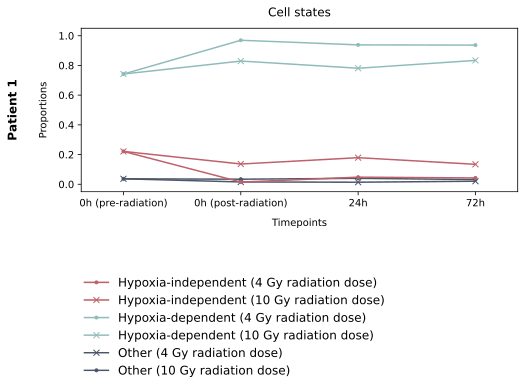

In [18]:
plot_props(patient1_4x, patient1_10x, r'$\mathbf{Patient\ 1}$', "p1_fig")

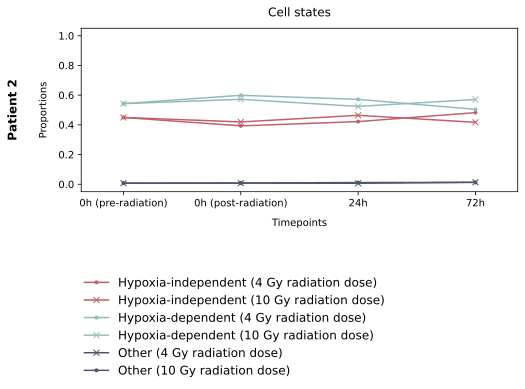

In [19]:
plot_props(patient2_4x, patient2_10x, r'$\mathbf{Patient\ 2}$', "p2_fig")

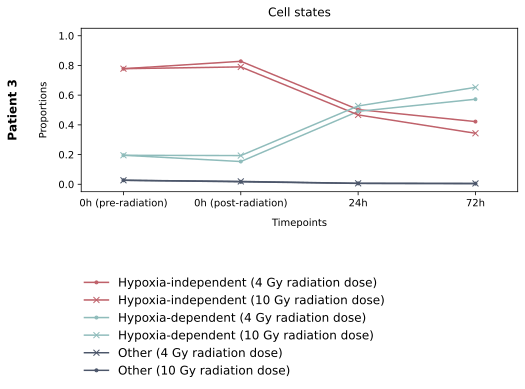

In [20]:
plot_props(patient3_4x, patient3_10x, r'$\mathbf{Patient\ 3}$', "p3_fig")